# <center>PROJECT-3. EDA + Feature Engineering


In [1]:
import re

import pandas as pd
import numpy as np
from  bs4 import BeautifulSoup
import requests 
import scipy.stats as stats
from geopy.geocoders import Nominatim
import category_encoders as ce
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  
from sklearn import metrics
from comet_ml import Experiment
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

In [2]:
experiment = Experiment(
    api_key='dvTasbKRODZA04cIRJBjekvYQ',
    project_name='hotelsscoreprediction',
    workspace='startrexii'
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/startrexii/hotelsscoreprediction/de1b4b9c560d4abbbe1a4addba64cc75



## Загрузка данных

In [3]:
hotels = pd.read_csv('./data/hotels.csv')

hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [4]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

## Очистка данных

In [5]:
hotels.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           2448
lng                                           2448
dtype: int64

In [6]:
# Заполним пропуски в значениях координат

'''
def find_coordiates(address: str, longitude :bool=False) -> float:
    """Функция по адресу определяет географические координаты

    Args:
        address (str): Строка с адресом
        longitude (bool, optional): Аргумент определяет какую составляющую координат необходимо вернуть. Defaults to False -> defaults returns latitude.

    Returns:
        float: Значение координаты
    """
    userAgent = 'your User-Agent'
    geolocator = Nominatim(user_agent=userAgent)
    
    location = geolocator.geocode(address) # Определяем локацию по адресу
    lat, lng = (location.latitude, location.longitude) # Выделяем географические координаты
    
    if longitude:
        return lng
    else:
        return lat

# Список отелей, у которых пропущен адрес
NotCoordHotelsLst = hotels.loc[hotels['lat'].isna(), 'hotel_name'].value_counts().index
# Координаты этих отелей
coordinates = {addr: (find_coordiates(addr), find_coordiates(addr, longitude=True)) for addr in NotCoordHotelsLst}
'''

coordinates = {
    'Fleming s Selection Hotel Wien City': (48.209405, 16.351257),
    'Hotel City Central': (48.2135658, 16.3799212),
    'Hotel Atlanta': (50.8520697, 4.354408380443903),
    'Maison Albar Hotel Paris Op ra Diamond': (48.875321, 2.321203),
    'Hotel Daniel Vienna': (48.1888627, 16.3838516356697),
    'Hotel Pension Baron am Schottentor': (48.216803, 16.357717),
    'Austria Trend Hotel Schloss Wilhelminenberg Wien': (48.2196753, 16.2854959),
    'NH Collection Barcelona Podium': (41.39188235, 2.1779639552623635),
    'Derag Livinghotel Kaiser Franz Joseph Vienna': (48.245891, 16.339740),
    'City Hotel Deutschmeister': (48.220855, 16.364423),
    'Holiday Inn Paris Montmartre': (48.8715708, 2.3436597),
    'Hotel Park Villa': (49.13646555, 9.230946491810585),
    'Cordial Theaterhotel Wien': (48.20966395, 16.35142625097432),
    'Roomz Vienna': (48.18672145, 16.420653090404993),
    'Mercure Paris Gare Montparnasse': (48.839752, 2.323791),
    'Hotel Advance': (27.9124545, 84.8838653),
    'Renaissance Barcelona Hotel': (41.3927154, 2.1674921)
}

In [7]:
hotels.loc[hotels['lat'].isna(), 'lat'] = hotels.loc[hotels['lat'].isna(), 'hotel_name'].apply(lambda x: coordinates[x][0])
hotels.loc[hotels['lng'].isna(), 'lng'] = hotels.loc[hotels['lng'].isna(), 'hotel_name'].apply(lambda x: coordinates[x][1])

In [8]:
hotels.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
dtype: int64

In [9]:
numbOfDuplicates = hotels.duplicated().sum()

# Удаляем дубликаты
hotels = hotels.drop_duplicates()
afterCleaning = hotels.shape[0]

print('Количество дубликатов в данных:', numbOfDuplicates)
print('Количество строк в датасете после очистки:', afterCleaning)

Количество дубликатов в данных: 307
Количество строк в датасете после очистки: 386496


array([[<Axes: title={'center': 'additional_number_of_scoring'}>,
        <Axes: title={'center': 'average_score'}>,
        <Axes: title={'center': 'review_total_negative_word_counts'}>],
       [<Axes: title={'center': 'total_number_of_reviews'}>,
        <Axes: title={'center': 'review_total_positive_word_counts'}>,
        <Axes: title={'center': 'total_number_of_reviews_reviewer_has_given'}>],
       [<Axes: title={'center': 'reviewer_score'}>,
        <Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lng'}>]],
      dtype=object)

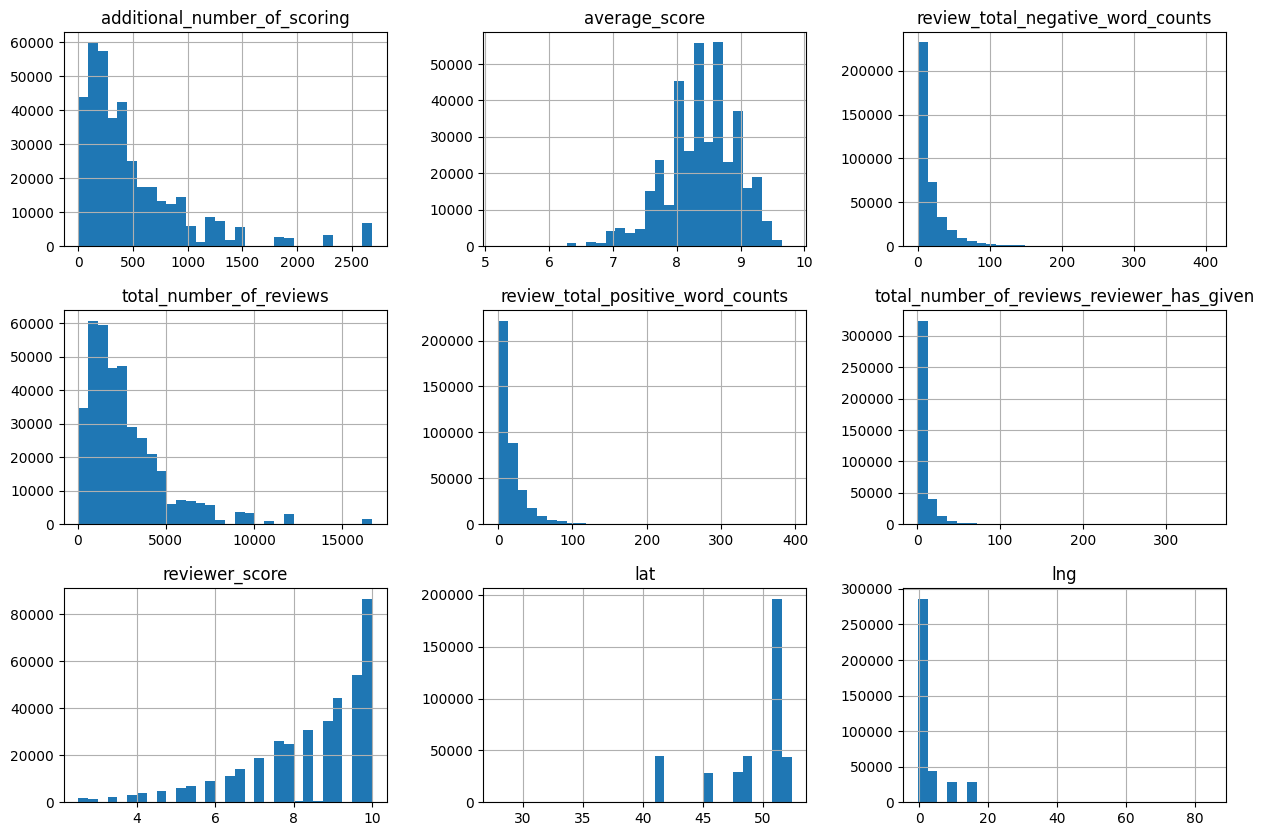

In [10]:
# Визуальный анализ распределений числовых признаков
numericalColumns = hotels.select_dtypes(include='number').columns.to_list()

hotels[numericalColumns].hist(figsize=(15, 10), bins=30)

**Вывод:** отсутствуют нормальные распределения(визуально), учтем это на анализе выбросов

In [11]:
# Удалим выбросы методом межквартильного размаха
def outliers_iqr(data: pd.DataFrame, feature: str, left: float=1.5, right: float=1.5, log_scale: bool=False) -> tuple:
    """Функция определеяет выбросы методом межквартильного размаха
    (Метод Тьюки)

    Args:
        data (pd.DataFrame): Исходный датасет
        feature (str): Признак для очистки
        left (float, optional): Левая граница нормальных значений(относительно ширины ящика). Defaults to 1.5.
        right (float, optional): Правая граница нормальных значений(относительно ширины ящика). Defaults to 1.5.
        log_scale (bool, optional): Логарифмирование признака. Defaults to False.

    Returns:
        tuple: Выбросы и очищенный датасет
    """
    if log_scale: # Логарифмирование
        x = np.log(data[feature])
    else:
        x = data[feature]
    
    # Границы ящика
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    
    iqr = quartile_3 - quartile_1
    
    # Порог нормальных значений
    upper_bound = quartile_3 + right*iqr
    lower_bound = quartile_1 - left*iqr
    
    outliers = data[(x<lower_bound) | (x>upper_bound)]
    cleaned = data[(x>lower_bound) & (x<upper_bound)]
    
    return outliers, cleaned

# Удалим выбросы для каждого признака с учетом распределения
for col in numericalColumns:
    outliers, hotels = outliers_iqr(hotels, col, left=3, right=4)
    print(f'Число выбросов по методу Тьюки в признаке "{col}": {outliers.shape[0]}')
    
print(f'Результирующее число записей: {hotels.shape[0]}')

Число выбросов по методу Тьюки в признаке "additional_number_of_scoring": 3587
Число выбросов по методу Тьюки в признаке "average_score": 44
Число выбросов по методу Тьюки в признаке "review_total_negative_word_counts": 7386
Число выбросов по методу Тьюки в признаке "total_number_of_reviews": 1351
Число выбросов по методу Тьюки в признаке "review_total_positive_word_counts": 5136
Число выбросов по методу Тьюки в признаке "total_number_of_reviews_reviewer_has_given": 9215
Число выбросов по методу Тьюки в признаке "reviewer_score": 0
Число выбросов по методу Тьюки в признаке "lat": 26
Число выбросов по методу Тьюки в признаке "lng": 0
Результирующее число записей: 358805


## Проектирование признаков

In [12]:
# Выделим страну отеля
def countryCreate(countryStr: str) -> str:
    """Функция выделяет страну из строки

    Args:
        countryStr (str): Строка, содержащая название страны

    Returns:
        str: Название страны
    """
    wordLst = countryStr.split() # Список всех слов в строке
    
    if wordLst[-1] == 'Kingdom':
        return ' '.join(wordLst[-2:])
    else:
        return wordLst[-1]


hotels['hotel_country'] = hotels['hotel_address'].apply(countryCreate)

# Удаляем лишнее
hotels = hotels.drop('hotel_address', axis=1)

In [13]:
# Получаем таблицу стран и их численности
# Ссылка на сайт с странами
'''url = 'http://en.ostranah.ru/_lists/population.php'
soup = BeautifulSoup(requests.get(url).text, 'html.parser')
table = soup.select('table')[0] # Получаем таблицу со странами(html-вид)

rows = table.find_all('td') # 

for i, tag in enumerate(rows): # Переводим тэги в текст, который в них содержится
    rows[i] = tag.text 

values = np.array_split(rows, len(rows) / 2)

populationDf = pd.DataFrame(
    data=values,
    columns=['hotel_country', 'Population']    
)

# Получаем таблицу стран и их площади
url = 'http://en.ostranah.ru/_lists/area.php'
soup = BeautifulSoup(requests.get(url).text, 'html.parser')
table = soup.select('table')[0] # Получаем таблицу со странами(html-вид)

rows = table.find_all('td') # 

for i, tag in enumerate(rows): # Переводим тэги в текст, который в них содержится
    rows[i] = tag.text 

values = np.array_split(rows, len(rows) / 2)

areaDf = pd.DataFrame(
    data=values,
    columns=['hotel_country', 'Area']    
)


# Объединяем все в одну таблицу
country = pd.merge(
    left=populationDf,
    right=areaDf,
    on='hotel_country'
)

# Убираем пробелы в начале строки
country['hotel_country'] = country['hotel_country'].apply(lambda x: x[1:])
country['Population'] = country['Population'].apply(lambda x: x.replace(' ', '')).astype('int')
country['Area'] = country['Area'].apply(lambda x: x.replace(' ', '')).astype('float')

country.to_csv('./data/country.csv', index=False)'''

"url = 'http://en.ostranah.ru/_lists/population.php'\nsoup = BeautifulSoup(requests.get(url).text, 'html.parser')\ntable = soup.select('table')[0] # Получаем таблицу со странами(html-вид)\n\nrows = table.find_all('td') # \n\nfor i, tag in enumerate(rows): # Переводим тэги в текст, который в них содержится\n    rows[i] = tag.text \n\nvalues = np.array_split(rows, len(rows) / 2)\n\npopulationDf = pd.DataFrame(\n    data=values,\n    columns=['hotel_country', 'Population']    \n)\n\n# Получаем таблицу стран и их площади\nurl = 'http://en.ostranah.ru/_lists/area.php'\nsoup = BeautifulSoup(requests.get(url).text, 'html.parser')\ntable = soup.select('table')[0] # Получаем таблицу со странами(html-вид)\n\nrows = table.find_all('td') # \n\nfor i, tag in enumerate(rows): # Переводим тэги в текст, который в них содержится\n    rows[i] = tag.text \n\nvalues = np.array_split(rows, len(rows) / 2)\n\nareaDf = pd.DataFrame(\n    data=values,\n    columns=['hotel_country', 'Area']    \n)\n\n\n# Объеди

In [14]:
country = pd.read_csv('./data/country.csv')

country

,hotel_country,Population,Area
0,China,1339450000,9596960.00
1,India,1187550000,3287590.00
2,United States,310241000,9372610.00
3,Indonesia,237556000,1919440.00
4,Brazil,193467000,8547000.00
...,...,...,...
188,San Marino,31800,61.00
189,Palau,20000,458.00
190,Nauru,14000,21.00
191,Tuvalu,10000,26.00


In [15]:
# Добавим площадь и численность страны отеля
hotels = pd.merge(
    left=hotels,
    right=country,
    on='hotel_country',
    how='left'
)

In [16]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'], dayfirst=False)

# Выделим период оценки отеля по первому и последнему отзывам
hotels['evaluation_period'] = (hotels.groupby('hotel_name')['review_date'].transform('max')
                            - hotels.groupby('hotel_name')['review_date'].transform('min')).dt.days

# Выделим все составляющие даты
hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_day'] = hotels['review_date'].dt.day
hotels['quarter'] = hotels['review_date'].dt.quarter
hotels['dayofweek'] = hotels['review_date'].dt.dayofweek

# Удаляем лишнее
hotels = hotels.drop('review_date', axis=1)

In [17]:
# Выделим 50 стран, из которых представлено больше всего рецензентов
reviewersCountries = hotels['reviewer_nationality'].value_counts().nlargest(50).index.to_list()

hotels['reviewer_nationality'] = hotels['reviewer_nationality']\
    .apply(lambda x: x if x in reviewersCountries else 'Other')

In [18]:
# Все отзывы очень разные, оставим только факт наличия негативного или позитивного отзыва
hotels['negative_review'] = hotels['review_total_negative_word_counts'].apply(
    lambda x: 'No Negative' if not x else 'Some negative words'
)

hotels['positive_review'] = hotels['review_total_positive_word_counts'].apply(
    lambda x: 'No Positive' if not x else 'Some positive words'
)

In [19]:
# Выделим разницу межу словами в положительном и отрицательном отзывах
hotels['diff_number_of_words'] = hotels['review_total_positive_word_counts']\
    - hotels['review_total_negative_word_counts']

In [20]:
def find_tags(tagString: str) -> list:
    """Функция преобразует строку с тегами в соответствующий список

    Args:
        tagString (str): Строка с тегами

    Returns:
        list: Список тегов
    """
    r = re.compile(r'(?<=\s)\w+.*\b') # Регулярное выражение для выделения тегов
    
    # Преобразуем строку с тегами
    tagString = r.findall(tagString)[0]
    
    tagList = tagString.split(" ', ' ")
    
    return tagList

# Преобразуем теги для дальнейшей работы
hotels['tags'] = hotels['tags'].apply(find_tags)

# Выделим количество тегов
hotels['tag_cnt'] = hotels['tags'].apply(lambda x: len(x))

In [21]:
# Словарь для поиска тега по ключевым словам
tagTypes = {
    'Pets': 'with a pet',
    'TripType': ('leisure trip', 'business trip'),
    'NumberOfPersons': ('couple', 'solo trav', 'group', 'family w', 'with friends'),
    'RoomType': '%',
    'Period': 'stayed ',
    'RatingDevice': 'device'
}


def createTagColumn(tagList: list, colType: str=None) -> str:
    """Функция возвращает тег, указанный рецензентом, в зависимости от типа тега

    Args:
        tagList (list): Все теги, которые указал рецензент
        colType (str, optional): Тип тега. Defaults to None.

    Returns:
        str: Название тега
    """
    i = 0 # Счетчик
    if colType == 'RoomType':
        for tag in tagList:
            for wordsToCheck in tagTypes.values():
                if type(wordsToCheck) is not tuple:
                    if wordsToCheck in tag.lower():
                        i += 1 # Если имеется слово, относящееся к тегам других типов, тег пропускается
                else:
                    for wordToCheck in wordsToCheck:
                        if wordToCheck in tag.lower():
                            i += 1
                    
            if i == 0: return tag # Если нет, этот тег является типом комнаты  
            i = 0  
        return 'Not Specified'
            
    # Все типы, кроме типа комнаты определяются перебором тегов в списке
    for tag in tagList:
        if type(tagTypes[colType]) is not tuple:
            if tagTypes[colType] in tag.lower():
                return tag
        else:
            for wordToCheck in tagTypes[colType]:
                if wordToCheck in tag.lower():
                    return tag
                
    return 'Not Specified'


# Создаем столбцы для каждого типа тега
for tagType in tagTypes.keys():
    hotels[tagType + '_tag'] = hotels['tags'].apply(createTagColumn, colType=tagType)

# Удаляем лишнее
hotels = hotels.drop('tags', axis=1)

In [22]:
# Выделим из тега количество дней, на которые останавливался рецензент
mask = hotels['Period_tag'] != 'Not Specified'
hotels.loc[mask, 'Stayed_days'] = hotels.loc[mask, 'Period_tag'].apply(lambda x: int(x.split()[1]))

# Сразу заполним пропущенные значения медианным 
hotels = hotels.fillna(
    {'Stayed_days': hotels.loc[mask, 'Stayed_days'].median()}
)

# Удаляем лишнее
hotels = hotels.drop('Period_tag', axis=1)

In [23]:
# Выделим количество дней между датой проверки и очистки
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))

In [24]:
# Доля действительных оценок без проверки по отношению к количеству отзывов
hotels['share_reviews_without_verification'] = (hotels['additional_number_of_scoring'] \
    / hotels['total_number_of_reviews']).round(2)

In [25]:
# Удалим неинформативные признаки, если они есть после создания новых признаков
uninformative_lst = []
for col in hotels.columns:
    
    repeat = hotels[col].value_counts(normalize=True).max() # Частота самого популярного признака
    uniq_freq = hotels[col].nunique() / hotels[col].count() # Процентное соотношение уникальных значений
    
    if (repeat > 0.95) | (uniq_freq > 0.95):
        uninformative_lst.append(col)

hotels = hotels.drop(uninformative_lst, axis=1)

print('Количество неинформативных признаков по первичному математическому анализу:', len(uninformative_lst),f'({uninformative_lst})')

Количество неинформативных признаков по первичному математическому анализу: 1 (['Pets_tag'])


In [26]:
# Заполним пропуски в полученных категориальных признаках
hotels['RatingDevice_tag'] = hotels['RatingDevice_tag']\
    .replace(['Not Specified', 'Submitted from a mobile device'], ['another device', 'mobile'])

hotels['TripType_tag'] = hotels['TripType_tag'].replace(
    'Not Specified',
    hotels['TripType_tag'].mode()[0]
)

# В типах комнат очень много значений, оставим 50 наиболее популярных
roomTypes = hotels['RoomType_tag'].value_counts().nlargest(50).index.to_list()

hotels['RoomType_tag'] = hotels['RoomType_tag'].apply(
    lambda x: x if x in roomTypes else 'Other'
)

In [27]:
# Выделим числовые и категориальные признаки
numericColumns = [s for s in hotels.columns if hotels[s].dtypes != 'object']

categoricalColumns = list(set(hotels.columns) - set(numericColumns))

In [28]:
# Перед кодированием и нормализацией проверим числовые признаки на нормальноcть тестом К-квадрат Д'Агостино
normal = []
for col in numericColumns:
    if stats.normaltest(hotels[col])[1] > 0.05: # Выберем уровень значимости 0.05
        normal.append(col)

normal

[]

**Вывод:** отсутствуют нормально распределенные числовые признаки(даже среди созданных)

## Кодирование и нормализация

In [29]:
# Создадим списки для определения типа кодирования для каждого признака
binaryLst = []
oneHotLst = []

for col in categoricalColumns:
    if hotels[col].nunique() > 15:
        binaryLst.append(col)
    else:
        oneHotLst.append(col)
        
# Binary encoding
encoder = ce.BinaryEncoder(cols=binaryLst)
binary_enc = encoder.fit_transform(hotels[binaryLst])
hotels = pd.concat([hotels, binary_enc], axis=1)

# One-Hot encoding
encoder = ce.OneHotEncoder(cols=oneHotLst, use_cat_names=True)
oneHot_enc = encoder.fit_transform(hotels[oneHotLst])
hotels = pd.concat([hotels, oneHot_enc], axis=1)

# Удаляем лишнее
hotels = hotels.drop(binaryLst + oneHotLst, axis=1)

In [30]:
# Нормализация
r_scaler = preprocessing.MinMaxScaler()
hotels_r = r_scaler.fit_transform(hotels.drop(['reviewer_score'], axis = 1))
hotels_r = pd.DataFrame(hotels_r, columns=hotels.drop(['reviewer_score'], axis = 1).columns)

## Отбор признаков

In [31]:
# Матрица корреляций
matrix = hotels_r.corr()

colPairs = [] # Пары столбцов
for i, col in enumerate(matrix.columns):
    for idx in matrix.columns[i+1:]:
        colPairs.append([col, idx])

corList = [] # Список пар столбцов с их коэффициентом корреляции
for elem in colPairs:
    corList.append((elem, matrix.loc[elem[1], elem[0]].round(2)))

# Список пар с сильной корреляцией    
strongCorr = list(filter(lambda x: True if abs(x[1]) > 0.8 else False, corList))

deleteLst = [] # Список столбцов, которые необходимо удалить из-за сильной корреляции с другими признаками

for colPair in strongCorr:
    deleteLst.append(colPair[0][0])
    
hotels_r = hotels_r.drop(set(deleteLst), axis=1)

## Модель

In [32]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей) 
X = hotels_r  
y = hotels['reviewer_score']

In [33]:
# Выбираем лучшие признаки
numericColumns.remove('reviewer_score')

num_cols = list(set(numericColumns) - set(deleteLst))

cat_cols = list(set(hotels_r.columns) - set(num_cols))

<Axes: title={'center': 'Влияние 22 лучших категориальных признаков'}>

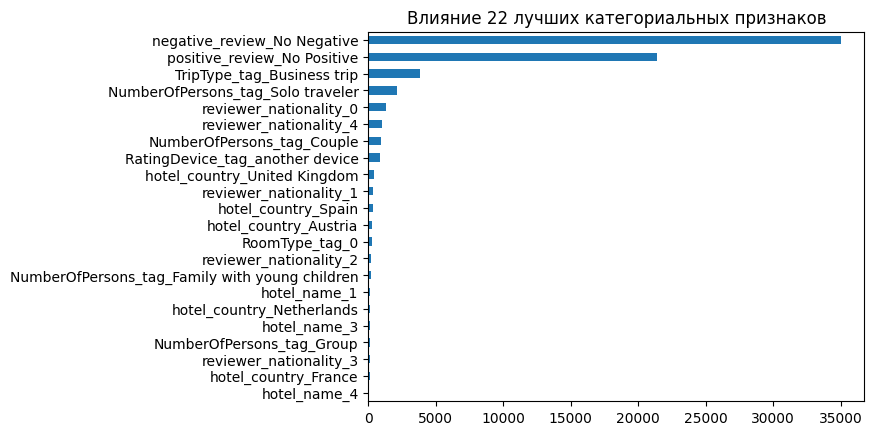

In [34]:
# Оценим 22 лучших категориальных признака
y1 = y.astype('int')
selector =  SelectKBest(chi2, k=22)
selector.fit(X[cat_cols], y1)


imp_cat = pd.Series(chi2(selector.transform(X[cat_cols]), y1)[0], index=X[cat_cols].columns[selector.get_support(indices=True)])
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title='Влияние 22 лучших категориальных признаков')

In [35]:
# Таблица с лучшими категориальными признаками
'''X_new_cat = pd.DataFrame(
    data=SelectKBest(f_classif, k=22).fit_transform(X[cat_cols], y1),
    columns=X[cat_cols].columns[selector.get_support(indices=True)]
)'''

'X_new_cat = pd.DataFrame(\n    data=SelectKBest(f_classif, k=22).fit_transform(X[cat_cols], y1),\n    columns=X[cat_cols].columns[selector.get_support(indices=True)]\n)'

<Axes: title={'center': 'Влияние 10 лучших количественных признаков'}>

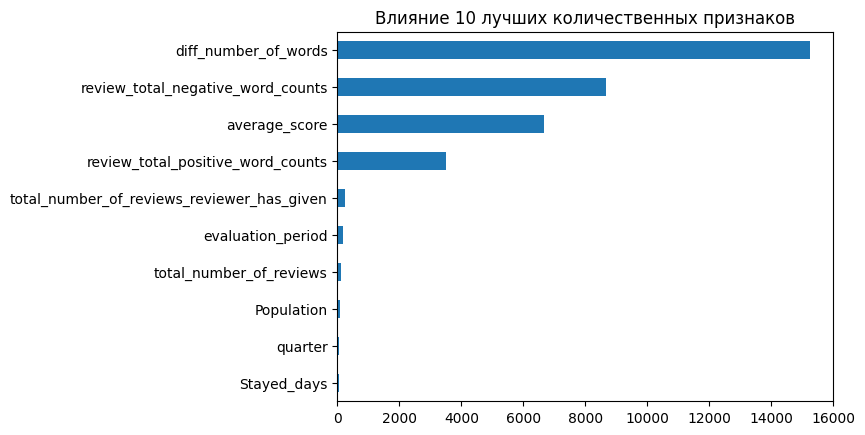

In [36]:
# Оценим 10 лучших числовых признаков
selector =  SelectKBest(f_classif, k=10)
selector.fit(X[num_cols], y1)


imp_cat = pd.Series(f_classif(selector.transform(X[num_cols]), y1)[0], index=X[num_cols].columns[selector.get_support(indices=True)])
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title='Влияние 10 лучших количественных признаков')

In [37]:
# Оставим 8 лучших числовых признаков
'''X_new_num = pd.DataFrame(
    data=SelectKBest(f_classif, k=10).fit_transform(X[num_cols], y1),
    columns=X[num_cols].columns[SelectKBest(f_classif, k=10).fit(X[num_cols], y1).get_support(indices=True)]
)'''

'X_new_num = pd.DataFrame(\n    data=SelectKBest(f_classif, k=10).fit_transform(X[num_cols], y1),\n    columns=X[num_cols].columns[SelectKBest(f_classif, k=10).fit(X[num_cols], y1).get_support(indices=True)]\n)'

In [38]:
# Объединяем в один итоговый датафрейм
'''X = pd.concat([X_new_cat, X_new_num], axis=1)'''

'X = pd.concat([X_new_cat, X_new_num], axis=1)'

In [39]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [40]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test) 

In [41]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
metric = metrics.mean_absolute_percentage_error(y_test, y_pred)
print('MAPE:', metric)

MAPE: 0.1338718081491471


In [42]:
Metrics = {'mape': metric}
experiment.log_metrics(Metrics)

parameters = {'data_shape': X_train.shape[1]}
experiment.log_parameters(parameters)

experiment.log_text('data prep,corr feature selection, norm MinMaxScaler, no best feature selection(big MAPE if using)')

experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/startrexii/hotelsscoreprediction/de1b4b9c560d4abbbe1a4addba64cc75
COMET INFO:   Metrics:
COMET INFO:     mape : 0.1338718081491471
COMET INFO:   Parameters:
COMET INFO:     data_shape : 53
COMET INFO:     k          : 10
COMET INFO:     score_func : <function f_classif at 0x000001D50297D080>
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     git metadata        : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO:     text-sample         : 1
COMET INFO: 
COMET WARNING: To get all d